# Lecture

Learnings on weight initialization for more efficient training
- If the h *w2 = logits, and we softmax(logits) to get our probability distribution, and we nll(softmax(logits)) to get our loss.  If w2 is semi-large, then we could end up getting logits like [3, 3, 30].  This doesn't make much sense, especially at initialization since our weights aren't trained.  Therefore, to reduce our initial loss, we can scale W2 down, which will make the logits smaller, making our Pr distribution smoother, and the loss smaller.  This will get rid of the 'hockey stick' style graphs that we see since the network no longer needs to squash down the logits before tuning them correctly.  This helps train our network more efficiently.


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random

names = open('names.txt', 'r').read().splitlines()
num_names = len(names)

# shuffle the names
random.shuffle(names)
num_train = int(num_names * 0.8)
num_val = int(num_names * 0.1)
num_test = num_names - num_train - num_val

# create the training, validation, and test sets
train_names = names[:num_train]
val_names = names[num_train:num_train+num_val]
test_names = names[num_train+num_val:]

In [197]:
hyperparams = {
    'epochs':10000,
    'K': 3,
    'neurons': 200,
    'block_size': 3,
    'lr': 0.1,
    'batch_size': 32,
}

# Unpack the hyperparameters from the dictionary
K = hyperparams['K']
neurons = hyperparams['neurons']
block_size = hyperparams['block_size']
epochs = hyperparams['epochs']
lr = hyperparams['lr']
batch_size = hyperparams['batch_size']

adjustment_epoch = epochs // 2
layer_size = K * block_size
loss_counts = []
num_names = len(names)

# Create a dictionary of characters and their indices
chars = sorted(list(set(''.join(names))))
char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i+1: c for i, c in enumerate(chars)}
char2idx['.'] = 0
idx2char[0] = '.'

# Build the dataset
X, Y = [], []

for name in names[:num_names]:
    name = name + '.'
    context = [0] * block_size      # The first context is a block of zeros which enables padding
    for c in name:
        X.append(context)
        Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
        context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character
        
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

# Embed the characters
C = torch.randn((27, K))
# Make the embedding 
emb = C[X]

In [44]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)
b1 = torch.randn(neurons)

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

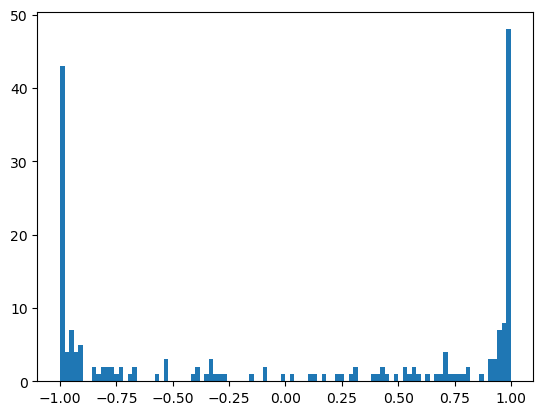

In [45]:
# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')



#### Learnings from a saturated tanh activation function

Ok this graph above shows the distributions for the activations from our first hidden layer.  Since the tanh squeezes input between -1 and 1, we have so much of our input there it's problematic because the derivative of tanh(-1) and tanh(1) are zero.  Which means that when we backpack prop through this, our gradients will not be updating since there's no derivative to go off of.  

The above graph just calculates this for the first example, let's extend this to all examples in our batch (at least for the first epoch)

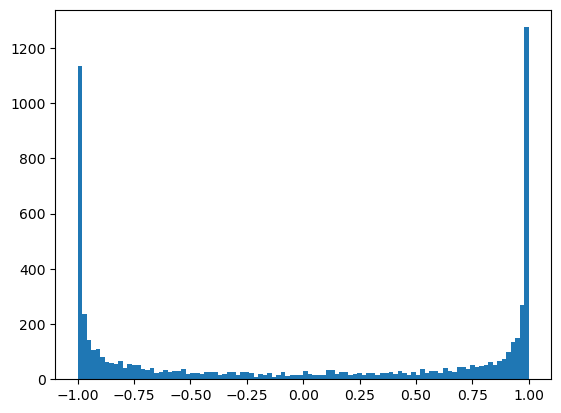

In [46]:
h_values = h.view(-1).tolist()
plt.hist(h_values, bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)

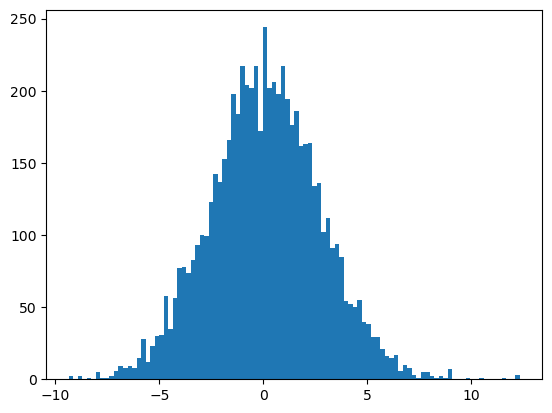

In [47]:
# Let's view the distribution of the first hidden layer pre-activation
hpreact_values = hpreact.view(-1).tolist()
plt.hist(hpreact_values, bins=100);

Note that anything less than -1 or greater than 1 gets squashed hard by the tail end of the tanh function.  So our hidden layer pre-activation distribution above is showing us that these values are way too broad.  Let's learn a bit more about just how extreme our activated tanh values are..

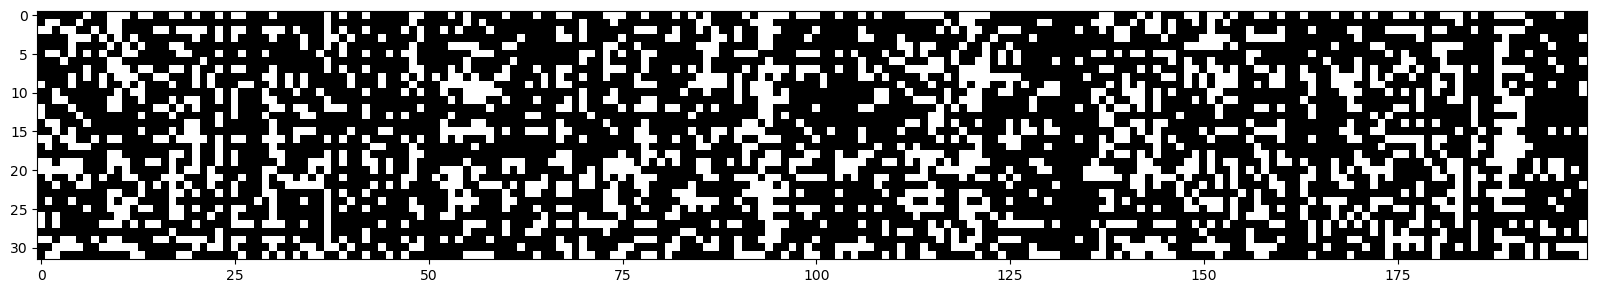

In [48]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')

Where the values are extreme (>.99) it will be painted white.  aka white pixel = bad.  If for any column here (or neuron), it was all white, it would indicate that for any example inputted to that neuron, all the values are squashed so much that the backprop won't work and that neuron is essentially a 'dead neuron'.  No example is activated in the 'active' part of the tanh.  Therefore this neuron never learns.  A nueron that's always spitting out -1 or 1 sucks because all the gradients on the way back essentially get zeroed out. 

We want neurons that update more frequently/train.  If hpreact was closer to zero, then the tanh activation tanh(~0) would be able to learn a lot more.  So let's squash the initial weights even more and see how the neuron activations changes from the picture above

In [81]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.3
b1 = torch.randn(neurons)               * 0.1

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    # plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')

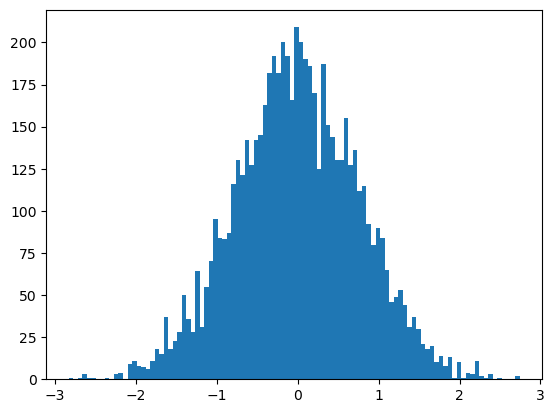

In [82]:
hpreact_values = hpreact.view(-1).tolist()
plt.hist(hpreact_values, bins=100);

This is a huge difference than the hpreact above before we didn't scale down W1, b1.  We went from a range of -10:10 to -1:1.  Let's see how this affected our activations

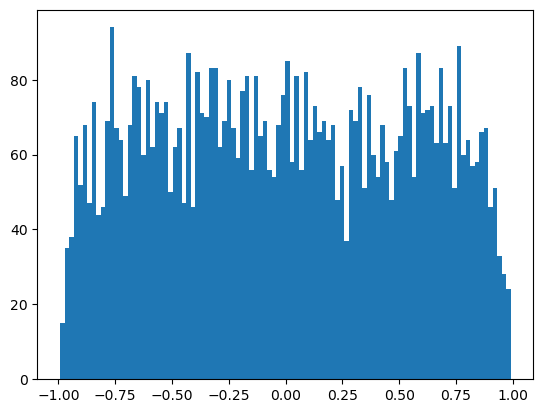

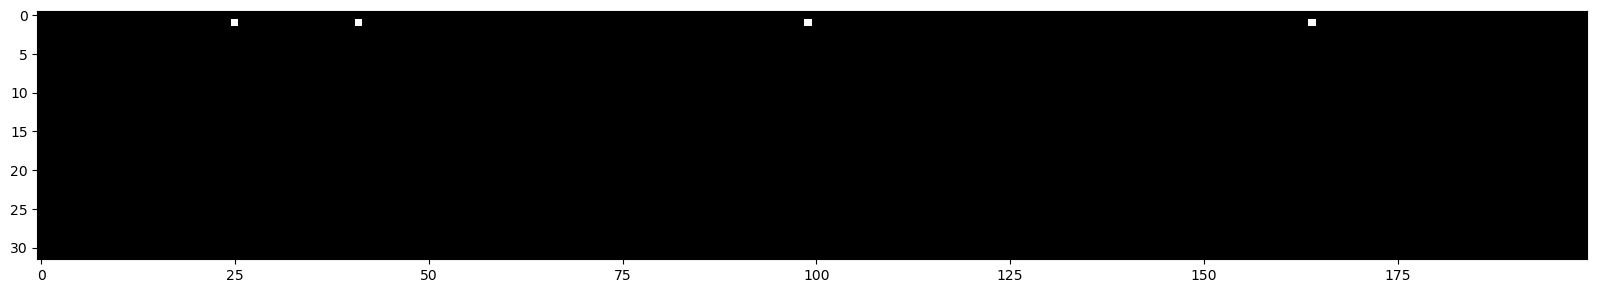

In [83]:
h_values = h.view(-1).tolist()
plt.hist(h_values, bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')



Holy crap, this is almost black.  Which means we have hardly any dead neurons anymore.  Every neuron is getting activated now and should be able to learn in backprop


- We don't want hpreact to be too small because then tanh does not do anything, and we don't want them to be too large because then tanh becomes saturated.  Hmm I understand the latter as we've just demonstrated that, but what happens when hpreact is super small?  Let's do a quick experiment and find out

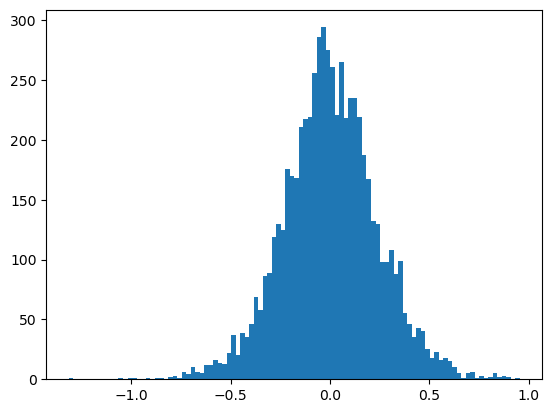

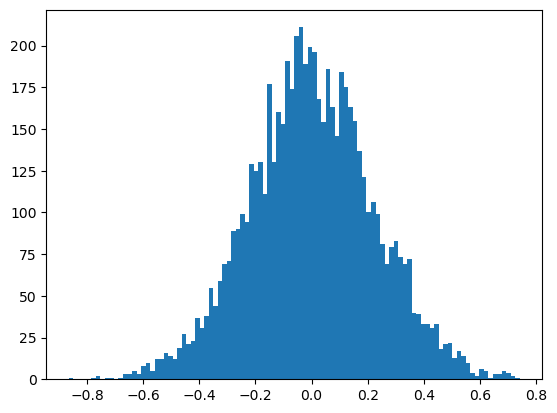

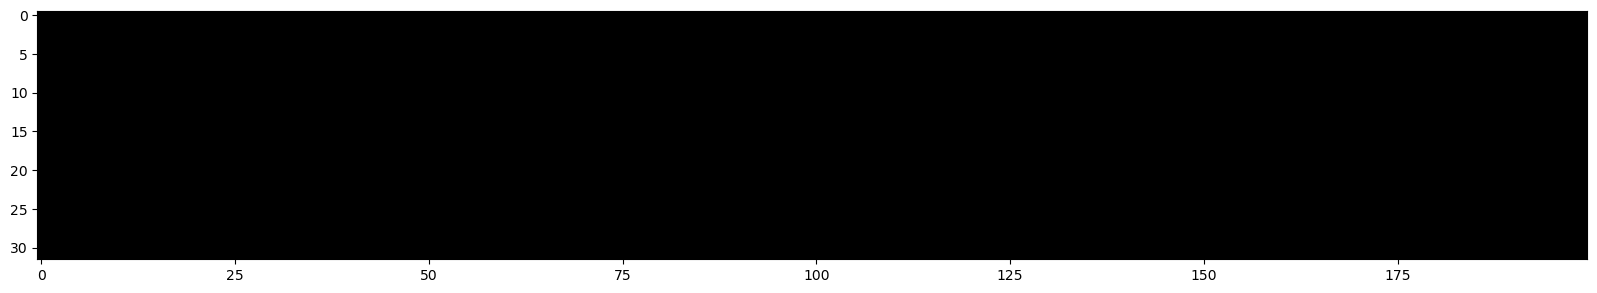

In [176]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.1
b1 = torch.randn(neurons)               * 0.01

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')
    elif epoch == epochs-5000:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)

    # Print the distribution of the first hidden layer
    # plt.hist(h[0].detach().numpy(), bins=100)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update the weights
    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        C -= lr * C.grad
        
    # Zero the gradients
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    C.grad.zero_()

    break   # TODO: Remove this line to train the model

weights = [C, W1, b1, W2, b2]
# print(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}, K={K}, neurons={neurons}, block_size={block_size}, epochs={epochs}')


plt.hist(hpreact.view(-1).tolist(), bins=100);
plt.show()

plt.hist(h.view(-1).tolist(), bins=100);   # wow this semi-colon supresses the print statement from plt.hist :)
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, interpolation='nearest', cmap='gray')

![tanh](images/tanh.png)

Ah I've figured it out, if we examine the tanh function between -1:1 it is almost a line. so basically a passthru linear function, so it doesn't do much with the input. Input ~= Output

The smaller the input, the less the tanh is doing, but at the same time we don't want them to be too large.  So we don't want the values to be close to zero and we dont' want large values that are saturated and are getting overly squashed.  We want our input to tanh to be roughly gaussian, so zero mean and one standard deviation, at least at initialization

### Batch Normalization
- We have hidden states, want them to be roughly gaussian, so why not take the hidden states and normalize them to be roughly gaussian

![batch norm](images/batch-norm.png)

- So we're going to subtract our input from the mean and then divide by the standard deviation to normalize our batch

#### Normalization

In [178]:
hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

tensor([ 7.4506e-09,  1.4901e-08,  2.2352e-08,  1.4901e-08,  0.0000e+00,
        -2.2352e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4901e-08,
        -2.9802e-08,  1.4901e-08,  2.9802e-08,  2.9802e-08,  0.0000e+00,
         0.0000e+00, -1.8161e-08,  2.9802e-08,  3.7253e-09, -1.4901e-08,
        -3.7253e-09, -5.9605e-08,  1.4901e-08, -3.3528e-08, -2.2352e-08,
        -7.4506e-09, -2.2352e-08, -1.4901e-08,  1.1176e-08, -2.9802e-08,
         2.9802e-08, -3.3528e-08, -2.5146e-08,  2.2352e-08, -1.7695e-08,
        -7.4506e-09, -3.7253e-09,  1.4901e-08,  0.0000e+00,  1.4901e-08,
         2.2352e-08, -1.4901e-08,  0.0000e+00, -2.2352e-08, -4.4703e-08,
         2.2352e-08,  3.7253e-08,  1.4901e-08,  0.0000e+00,  0.0000e+00,
        -2.2352e-08,  1.4901e-08, -2.2352e-08, -1.4901e-08, -1.4901e-08,
         2.2352e-08,  7.4506e-09,  2.9802e-08, -2.9802e-08, -7.4506e-09,
         0.0000e+00,  1.4901e-08,  9.3132e-09, -4.4703e-08, -2.2352e-08,
         0.0000e+00,  1.6764e-08,  1.4901e-08, -3.7

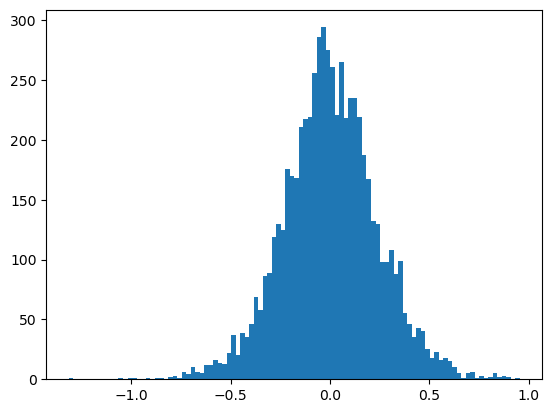

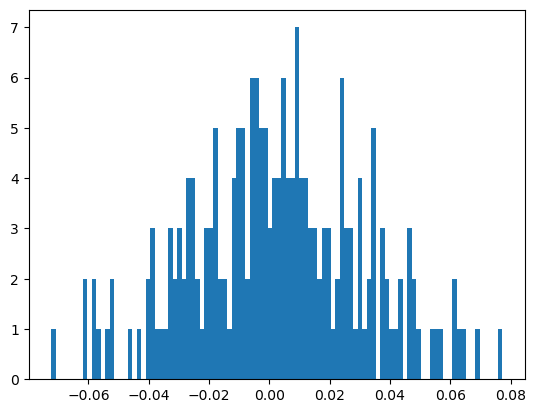

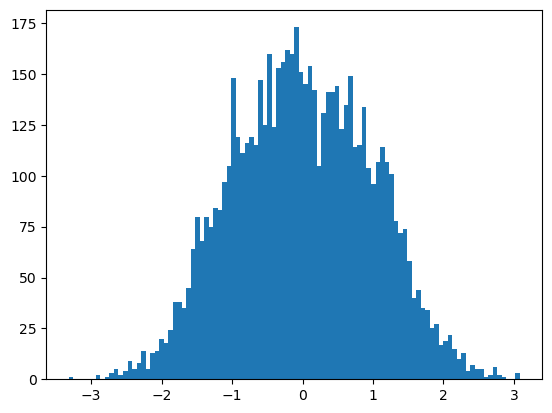

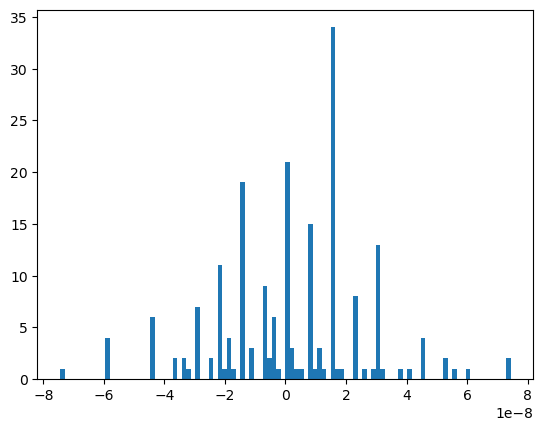

In [179]:
plt.hist(hpreact.view(-1).tolist(), bins=100);
plt.show()
plt.hist(hpreact.mean(0, keepdim=True).view(-1).tolist(), bins=100);
plt.show()

#### Scale and Shift 

- Now we want our hpreact to be roughly unit guassian at initialization but not necessarily throughout the training of our network.  We want to let the gradients shift our distributions as needed and let tanh activate where it needs to, and let it passthrough otherwise.  
- To implement this, we are going to do a 'shift and scale' as show in the image above and introduce a gain and bias
- `bngain` and `bnbias` are the scale and shift parameters for batch normalization.
- `hpreactNorm` is normalized for a gaussian distribution
- At initialization, `bngain` and `bnbias` are set to 1 and zero respectively as to preserve a unit guassian distribution (aka leave `hpreactNorm` alone).  However during training, these parameters are updated so that the distribution can be changed by the NN from a gaussian to whatever the NN needs

$$ hpreact = emb @ W1 + b1 $$
$$ hpreactNorm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) $$
$$ hpreact = bngain * hpreactNorm + bnbias $$

    

In [199]:
# construct the first hidden layer
W1 = torch.randn(layer_size, neurons)   * 0.1
b1 = torch.randn(neurons)               * 0.01

# construct the output layer
W2 = torch.randn(neurons, 27)
W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
b2 = torch.randn(27) * 0

# Batch normalization Scale and shift
# These values are initialized to 1 and 0 respectively to keep a guassian distribution
bngain = torch.ones((1, neurons))
bnbias = torch.zeros((1, neurons))

# Set the parameters to require gradients
parameters = [W1, b1, W2, b2, C, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

# Forward pass
for epoch in range(epochs):
    # Tune the learning rate and batch size
    if epoch == adjustment_epoch:
        lr = lr / 10
        batch_size = batch_size * 10
        print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

    rand_batch_idx = torch.randint(0, num_names, (batch_size,))
    x_batch = X[rand_batch_idx]
    y_batch = Y[rand_batch_idx]

    # Embed the characters
    emb = C[x_batch]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, y_batch)
    loss_counts.append(loss.item())
    
    # Backward pass
    loss.backward()

    # Update the weights
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    # Zero the gradients
    for p in parameters:
        p.grad.zero_()

Adjusting learning rate to 0.01, batch_size=320


Text(0.5, 1.0, 'Loss over time')

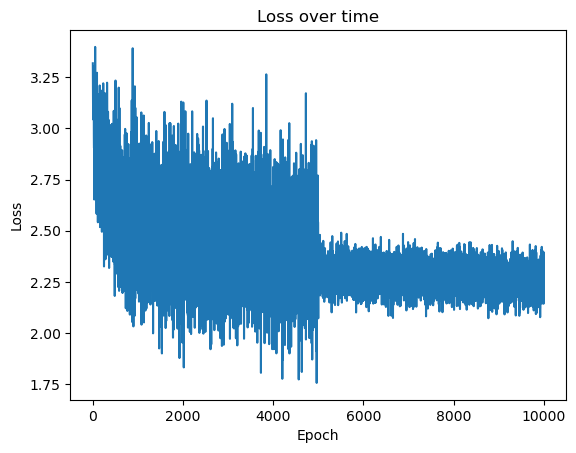

In [205]:
# Plot the loss
plt.plot(loss_counts)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss over time')
# plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')


Adjusting learning rate to 0.01, batch_size=320


(2.1659204959869385, 2.18731427192688)

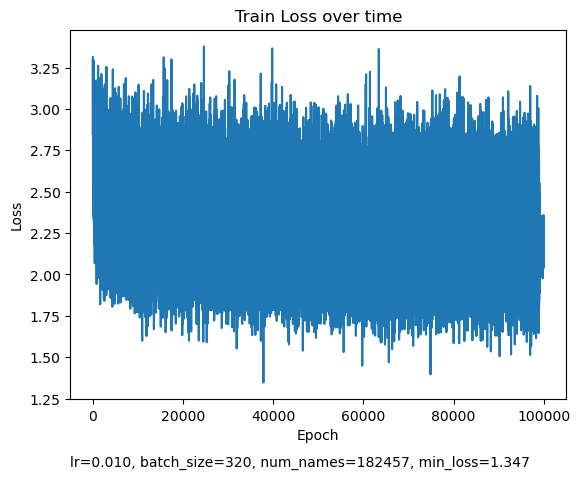

In [235]:
# train the model
def train_model(x, y, plot=True):
    hyperparams = {
        'epochs':1000,
        'K': 3,
        'neurons': 200,
        'block_size': 3,
        'lr': 0.1,
        'batch_size': 32,
    }

    # Unpack the hyperparameters from the dictionary
    K = hyperparams['K']
    neurons = hyperparams['neurons']
    block_size = hyperparams['block_size']
    epochs = hyperparams['epochs']
    lr = hyperparams['lr']
    batch_size = hyperparams['batch_size']

    adjustment_epoch = epochs - 1000
    layer_size = K * block_size
    loss_counts = []

    # Embed the characters
    C = torch.randn((27, K))

    # construct the first hidden layer
    W1 = torch.randn(layer_size, neurons)   * 0.1
    b1 = torch.randn(neurons)               * 0.01

    # construct the output layer
    W2 = torch.randn(neurons, 27)
    W2 = W2 * 0.01  # Initialize the weights to be small for a good starting point (prevent false overconfidence)
    b2 = torch.randn(27) * 0

    # Batch normalization Scale and shift
    # These values are initialized to 1 and 0 respectively to keep a guassian distribution
    bngain = torch.ones((1, neurons))
    bnbias = torch.zeros((1, neurons))

    # Set the parameters to require gradients
    parameters = [W1, b1, W2, b2, C, bngain, bnbias]

    num_names = x.shape[0]

    for p in parameters:
        p.requires_grad = True

    # Forward pass
    for epoch in range(epochs):
        # Tune the learning rate and batch size
        if epoch == adjustment_epoch:
            lr = lr / 10
            batch_size = batch_size * 10
            print(f'Adjusting learning rate to {lr}, batch_size={batch_size}')

        rand_batch_idx = torch.randint(0, num_names, (batch_size,))
        x_batch = x[rand_batch_idx]
        y_batch = y[rand_batch_idx]

        # Embed the characters
        emb = C[x_batch]
        emb = emb.view(-1, layer_size)

        # Calculate the first hidden layer
        hpreact = emb @ W1 + b1
        hpreact_norm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # normalize
        hpreact = bngain * hpreact_norm + bnbias                                                # scale and shift
        h = torch.tanh(hpreact)

        logits = h @ W2 + b2

        # Calculate the loss
        loss = F.cross_entropy(logits, y_batch)
        loss_counts.append(loss.item())
        
        # Backward pass
        loss.backward()

        # Update the weights
        with torch.no_grad():
            for p in parameters:
                p -= lr * p.grad
            
        # Zero the gradients
        for p in parameters:
            p.grad.zero_()

    if plot:
        # Plot the loss
        plt.plot(loss_counts)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Train Loss over time')
        plt.annotate(f'lr={lr:.3f}, batch_size={batch_size}, num_names={num_names}, min_loss={min(loss_counts):.3f}', (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
    
    return C, W1, b1, W2, b2, bngain, bnbias

# evaluate the training and validation loss
def evaluate_loss(X, Y):
    # Embed the characters
    emb = C[X]
    emb = emb.view(-1, layer_size)

    # Calculate the first hidden layer
    hpreact = emb @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)

    logits = h @ W2 + b2

    # Calculate the loss
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def get_input_output(names):
    # Create a dictionary of characters and their indices
    chars = sorted(list(set(''.join(names))))
    char2idx = {c: i+1 for i, c in enumerate(chars)}
    idx2char = {i+1: c for i, c in enumerate(chars)}
    char2idx['.'] = 0
    idx2char[0] = '.'

    # Build the dataset
    X, Y = [], []

    for name in names:
        name = name + '.'
        context = [0] * block_size      # The first context is a block of zeros which enables padding
        for c in name:
            X.append(context)
            Y.append(char2idx[c])      # The next character is context[-1] (the last character in the context)
            context = context[1:] + [char2idx[c]]   # Crop & shift the context by one character

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y
        
x_train, y_train = get_input_output(train_names)
x_val, y_val = get_input_output(val_names)

# train the model
C, W1, b1, W2, b2, bngain, bnbias = train_model(x_train, y_train)

train_loss = evaluate_loss(x_train, y_train)
val_loss = evaluate_loss(x_val, y_val)

train_loss, val_loss

The following

```
    hyperparams = {
        'epochs':100000,
        'K': 3,
        'neurons': 200,
        'block_size': 3,
        'lr': 0.1,
        'batch_size': 32,
    }
```

helped me to achieve a training and validation loss of (2.1659, 2.1873).  all time high :)

An interesting point Andrej makes about batch normalization is that if we look at 

$$ hpreact = emb @ W1 + b1 $$
$$ hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias $$
$$ h = torch.tanh(hpreact) $$

It's kind of weird that `h` is being influenced by the distribution of our input, which in this case is a batch.  The hidden layer activation is actually being influenced by the other input examples included in our batch.

In [231]:
train_loss, val_loss

(2.8198039531707764, 2.81711483001709)

# Let's view the distribution of the first hidden layer pre-activation
hpreact_values = hpreact.view(-1).tolist()
plt.hist(hpreact_values, bins=100);

Text(0.5, 1.0, 'Loss over time')

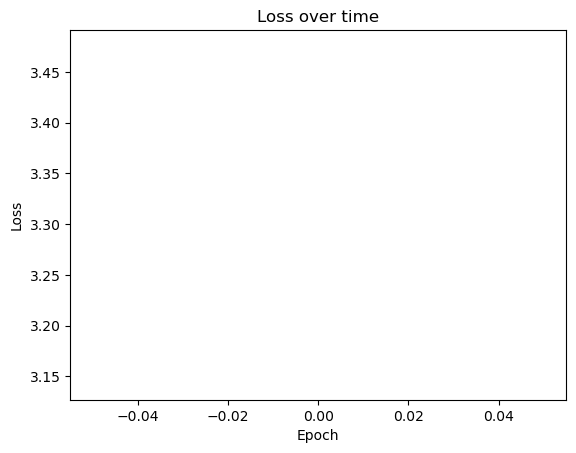

In [10]:


# Train the model with the best hyperparameters on the training set
weights = train(
    train_names,
    hyperparams
)

NameError: name 'train' is not defined

Video: https://www.youtube.com/watch?v=P6sfmUTpUmc


Exercises:
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.
